In [124]:
import os
import logging
import glob
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [125]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print("TensorFlow version: ", tf.__version__)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
gpus

TensorFlow version:  2.16.1
1 Physical GPUs, 1 Logical GPUs


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [126]:
data_path = "../data"
prep_data_path = "../prep_data"


classes = ['Desyatki',
            'Dvadcatki',
            'fizfuck',
            'himfuck',
            'matmekh',
            'pmpu',
            'Shayba'
]
num_classes = len(classes)
classes

['Desyatki', 'Dvadcatki', 'fizfuck', 'himfuck', 'matmekh', 'pmpu', 'Shayba']

In [127]:
#for cl in classes:
#    img_path = os.path.join(data_path, cl)
#    images = glob.glob(img_path + '/*.jpg')
#    print(f"{cl} : {len(images)} Images")
#    train, val, test = images[:round(len(images)*0.7)], images[round(len(images)*0.7):round(len(images)*0.85)], images[round(len(images)*0.85):]
#
#    for t in train:
#        if not os.path.exists(os.path.join(prep_data_path, 'train', cl)):
#            os.makedirs(os.path.join(prep_data_path, 'train', cl))
#        shutil.copy(t, os.path.join(prep_data_path, 'train', cl))
#
#    for v in val:
#        if not os.path.exists(os.path.join(prep_data_path, 'val', cl)):
#            os.makedirs(os.path.join(prep_data_path, 'val', cl))
#        shutil.copy(v, os.path.join(prep_data_path, 'val', cl))
#
#    for ts in train:
#        if not os.path.exists(os.path.join(prep_data_path, 'test', cl)):
#            os.makedirs(os.path.join(prep_data_path, 'test', cl))
#        shutil.copy(ts, os.path.join(prep_data_path, 'test', cl))


In [128]:
train_dir = os.path.join(prep_data_path, "train")
val_dir = os.path.join(prep_data_path, "val")
test_dir = os.path.join(prep_data_path, "test")

total_train = sum(len(os.listdir(os.path.join(train_dir, cl))) for cl in classes)
total_val = sum(len(os.listdir(os.path.join(val_dir, cl))) for cl in classes)
total_test = sum(len(os.listdir(os.path.join(test_dir, cl))) for cl in classes)


2024-05-06 02:10:40.509441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


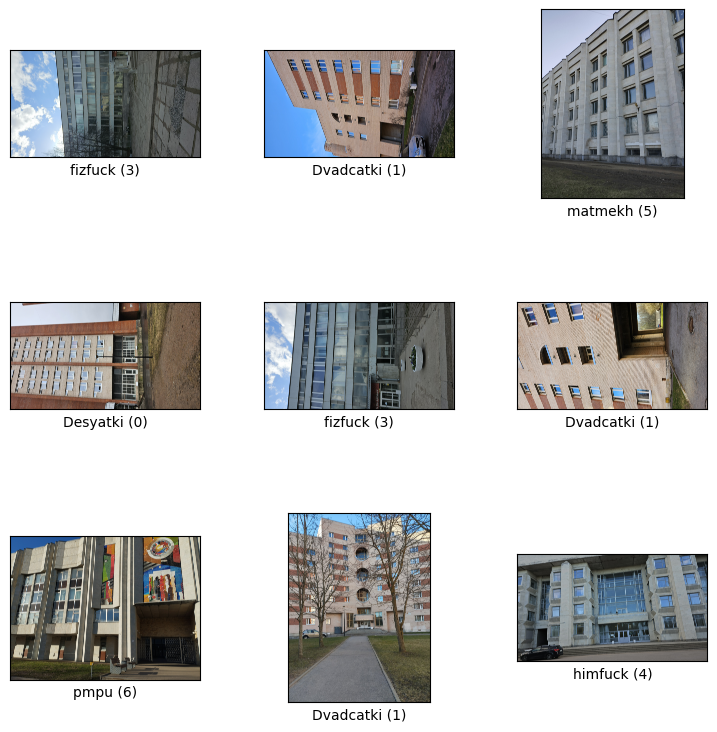

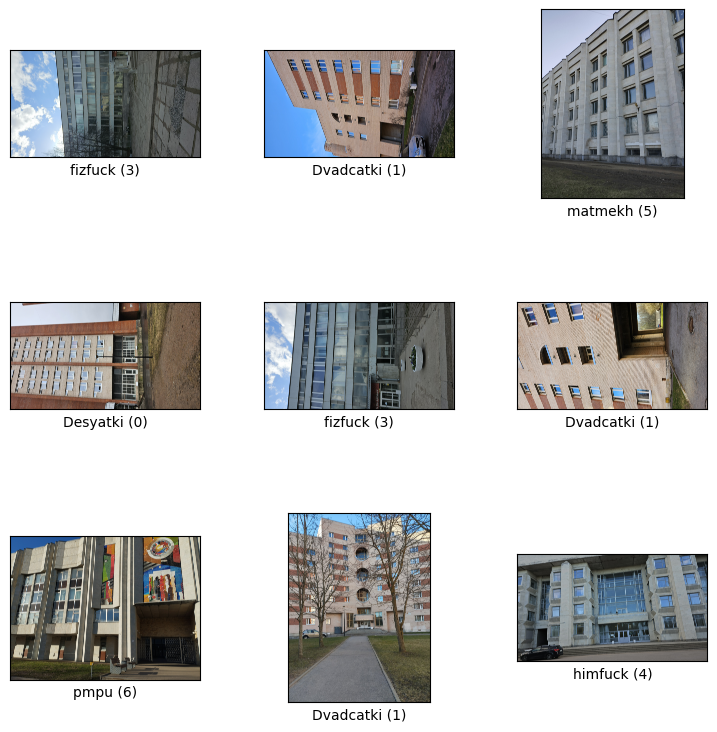

In [129]:
IMG_SHAPE = 224

builder = tfds.ImageFolder(prep_data_path, shape=(None, None, 3))

train_set = builder.as_dataset(split='train', shuffle_files=True, as_supervised=True)
val_set = builder.as_dataset(split='val', shuffle_files=True, as_supervised=True)
test_set = builder.as_dataset(split='test', as_supervised=True)
tfds.show_examples(train_set, builder.info)

In [130]:
def normalize_and_resize(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    image /= 255
    return image, label

train_set = train_set.map(normalize_and_resize).cache()
val_set = val_set.map(normalize_and_resize).cache()
test_set = test_set.map(normalize_and_resize).cache()

In [131]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
])

In [132]:
model = tf.keras.models.Sequential([
    layers.InputLayer(shape=(IMG_SHAPE,IMG_SHAPE,3)),
    layers.Conv2D(32, (5, 5), padding="same", activation='relu'),
    layers.Conv2D(32, (3, 3), padding="same", activation='relu', strides=2),
    layers.Conv2D(64, (5, 5), padding="same", activation='relu'),
    layers.Conv2D(64, (3, 3), padding="same", activation='relu', strides=2),
    layers.Conv2D(128, (5, 5), padding="same", activation='relu'),
    layers.Conv2D(128, (3, 3), padding="same", activation='relu', strides=2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [133]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 56, 56, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,306,279 (50.76 MB)

 Trainable params: 13,306,279 (50.76 MB)

 Non-trainable params: 0 (0.00 B)

In [134]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [136]:
checkpoint_path = "../trained_models/ckpt/checkpoint.model.keras"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)

In [137]:
BATCH_SIZE = 32
EPOCHS = 80

train_set = train_set.cache().repeat().map(lambda x, y: (data_augmentation(x, training=True), y)).shuffle(total_train).batch(BATCH_SIZE)
val_set = val_set.cache().repeat().map(lambda x, y: (data_augmentation(x, training=True), y)).shuffle(total_val).batch(BATCH_SIZE)

history = model.fit(
    train_set, validation_data=val_set, batch_size=BATCH_SIZE,
    epochs=EPOCHS, steps_per_epoch=int(total_train/BATCH_SIZE), validation_steps=int(total_val/BATCH_SIZE), callbacks=[cp_callback]
)

Epoch 1/80


2024-05-06 02:11:30.763129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:481: Filling up shuffle buffer (this may take a while): 363 of 1986
2024-05-06 02:11:50.795987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:481: Filling up shuffle buffer (this may take a while): 1107 of 1986
2024-05-06 02:12:10.977373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:481: Filling up shuffle buffer (this may take a while): 1795 of 1986
2024-05-06 02:12:17.013767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-05-06 02:12:17.126628: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2320 - loss: 1.9245
Epoch 1: val_loss improved from inf to 1.89858, saving model to ../trained_models/ckpt/checkpoint.model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 88s 300ms/step - accuracy: 0.2323 - loss: 1.9243 - val_accuracy: 0.2500 - val_loss: 1.8986
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2326 - loss: 1.9106
Epoch 2: val_loss improved from 1.89858 to 1.88528, saving model to ../trained_models/ckpt/checkpoint.model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.2327 - loss: 1.9104 - val_accuracy: 0.2260 - val_loss: 1.8853
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2832 - loss: 1.7733
Epoch 3: val_loss improved from 1.88528 to 1.37346, saving model to ../trained_models/ckpt/checkpoint.model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.2840 - loss: 1.7712 - val_accuracy: 0.4135 - val_loss: 1.3735
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accurac

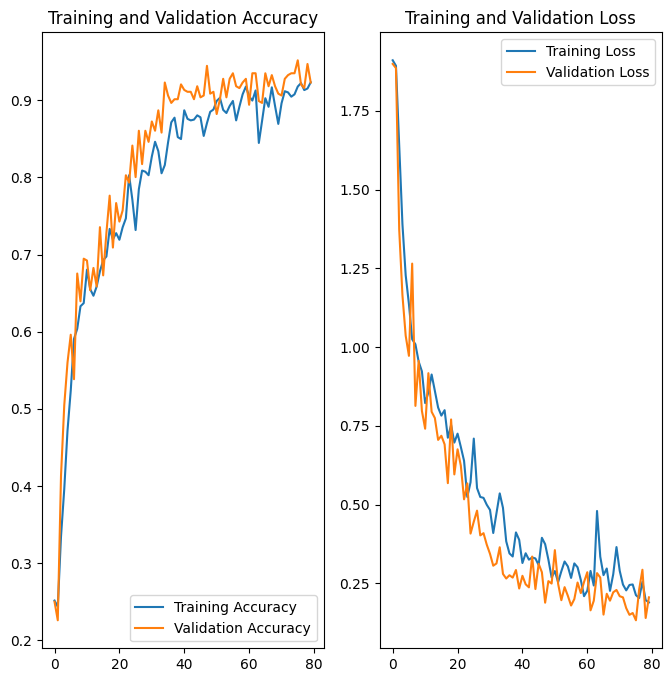

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [139]:
model.load_weights(checkpoint_path)

test_set = test_set.cache().repeat(5).batch(32)

results = model.evaluate(test_set, batch_size=32)

  1/311 ━━━━━━━━━━━━━━━━━━━━ 6:59 1s/step - accuracy: 0.9688 - loss: 0.1183

2024-05-06 02:27:25.510556: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


311/311 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.9252 - loss: 0.1916
